# Mount Google Drive to access files

---
# Imports & Config  

## Config

In [0]:
import os

base_dir = "/content/gdrive/My Drive/Masterarbeit"
object_detection_dir = os.path.join(base_dir, "ObjectDetection")
image_classification = os.path.join(base_dir, "ImageClassification")

classes_dict_file = object_detection_dir + "/classes.pkl"
objects_dict_file = object_detection_dir + "/objects.pkl"
images_dict_file = object_detection_dir + "/images.pkl"

## Connect to GPU

In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [0]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

TPU address is grpc://10.87.93.34:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 6005017964602350324),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 17537578373354958693),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 6340505640419897335),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 13133146263969677974),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 9248057101367089695),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 281354276562644553),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 13685777752437667117),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 4291063886531766030),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 2375977

## Mount GDrive

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Save & Load for pkls

In [0]:
import collections
import pickle as pkl

pkl_vars = {"objects": objects_dict_file,
            "images": images_dict_file,
            "classes": classes_dict_file}

def get_OD(var, force=False):
  if not var in globals() or force:
    print("loading {} from pickle".format(var))
    try:
      with open(pkl_vars[var], "rb") as f:
        return pkl.load(f)
    except:
      return collections.OrderedDict()
  elif var in globals():
    print("using already defined {}".format(var))
    return globals()[var]
  print("Failed to find something existing, creating new OrderedDictioniary for {}".format(var))
  return collections.OrderedDict()


def save_OD(var, local_var = None):
  if local_var is not None:
    print("Saving {} from handover variable".format(var))
    with open(pkl_vars[var], "+wb") as f:
      pkl.dump(local_var, f)
  elif var in globals():
    print("Saving {} from globals".format(var))
    with open(pkl_vars[var], "+wb") as f:
      pkl.dump(globals()[var], f)
  else:
    print("Failed to find something, unable to save {}".format(var))
    
def create_class_id(class_dict, prefix):
  if len(class_dict) == 0:
    class_int = 1
  else:
    class_int = int(next(reversed(class_dict))[2:])+1
  class_id = "{}{}".format(prefix, class_int)
  return class_id, class_int

## Replace print by prettyprint

In [0]:
from pprint import PrettyPrinter

pp = PrettyPrinter(indent=2)
def print(kwargs):
  pp.pprint(kwargs)
  

---
# Object Detection

## Imports

In [0]:
!git clone https://github.com/tensorflow/models.git /content/tf
!cd /content/tf/research; protoc object_detection/protos/*.proto --python_out=.
!cd /content/tf/research; export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim; python /content/tf/research/object_detection/builders/model_builder_test.py

Cloning into '/content/tf'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 24205 (delta 0), reused 0 (delta 0), pack-reused 24203
Receiving objects: 100% (24205/24205), 563.36 MiB | 26.10 MiB/s, done.
Resolving deltas: 100% (14318/14318), done.
Checking out files: 100% (2767/2767), done.
......................
----------------------------------------------------------------------
Ran 22 tests in 0.125s

OK


In [0]:
import os
import sys

# For running inference on the TF-Hub module.
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image.
#import matplotlib.pyplot as plt
#import tempfile
#from six.moves.urllib.request import urlopen
#from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import cv2

# For measuring the inference time.
from datetime import datetime

#for xml parsing
from bs4 import BeautifulSoup

#...
sys.path.append('tf/research')
sys.path.append('tf/research/slim')
from object_detection.utils import dataset_util, config_util
from object_detection import model_main

## Flags

In [0]:
class FLAGS_OD:
  image_dir = os.path.join(object_detection_dir, "Images")
  
  #tf records directory
  tf_records_dir = os.path.join(object_detection_dir, "TFRecords")
  #label_map directory
  label_map_dir = os.path.join(object_detection_dir, "LabelMaps")
  
  #class level to be considered
  class_level = [0,1]
  #how often the class of an object needs to occure to be considered
  min_class_occurence = 20
  
  #dataset split
  testing_percentage = 10
  validation_percentage = 10
  
  #pipeline config
  pipeline_config_dir = os.path.join(object_detection_dir, "ConfigFiles")
  
  #model checkpoints
  model_checkpoint_dir = os.path.join(object_detection_dir, "ModelCheckpoints")
  model_dir = os.path.join(object_detection_dir,"Models")

## Visualize Stuff

In [0]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

## Create Dataset

In [0]:
def load_annotation(file_path,infos):
  """
  Load annotation file for a given image and parse xml to dict.
  Args:
    img_name: string of the image name.
    infos: dict with information that should be appended to image dict
  Returns:
    dict of the image with all infos
  """
  xml = ""
  with open(file_path, 'r') as f:
    xml = f.readlines()
  xml = ''.join([line.strip('\t') for line in xml])
  bs = BeautifulSoup(xml)
  image_filename = os.path.join(*(file_path.split(os.sep)[:-1]))
  filename = bs.filename.string.replace("\n","").replace("\t","").replace(" ","")
  image_filename = os.path.join(image_filename, filename)
  image = {"filename": image_filename.replace("\n",""),
           "size": {"width": int(bs.size.width.string),
                    "height": int(bs.size.height.string)},
           "objects": []}
  for key, val in infos.items():
    image[key] = val

  for ob in bs.find_all("object"):
    obj = {"name": ob.find('name').string,
           "bndbox":{"xmin": int(ob.bndbox.xmin.string),
                     "xmax": int(ob.bndbox.xmax.string),
                     "ymin": int(ob.bndbox.ymin.string),
                     "ymax": int(ob.bndbox.ymax.string)},
           "pose":ob.pose.string,
           "truncated": bool(ob.truncated.string),
           "difficult": bool(ob.difficult.string)}
    image["objects"].append(obj)
  return image

In [0]:
def get_xml_files(root_dir):
  """Gets all xml files recursively inside the root directory
  and returns the file names with the path
  Args:
    root_dir: root directory as string
  Returns:
    list of tuples with file_name and path_name relative from
        root_dir
  """
  file_list = []

  for path, _, files in tf.gfile.Walk(root_dir):
    for file in files:
      if file.split(".")[-1] == "xml":
        root_f = root_dir.split(os.sep)
        path_f = path.split(os.sep)
        rel_path = [f for f in path_f if f not in root_f]
        rel_path = os.path.join(*rel_path)
        file_list.append((file, rel_path))
  
  return file_list
  

In [0]:
class TrainValTestSplit:
  """This class helps in assigning a train, validation or test
  label while making sure the datasets have a similar distribution
  of classes. Helpful for small datasets
  """
  #TODO init with objects list to get actual dist
  def __init__(self, testing_percentage=10, validation_percentage=10):
    """
    Args:
      testing_percentage: int percentage of dataset that should go to test
      validation_percentage: int percentage of dataset that should go to validate
    """
    self.tr = testing_percentage
    self.v = validation_percentage
  #TODO leverage actual dist to adjust label if necessary  
  #TODO check that the distribution in all sets is the same
  #-- distribution over classes, shelf_type
  def next_label(self):
    percentage = np.random.randint(1,100)
    if percentage < self.tr:
      return "test"
    elif percentage < (self.tr + self.v):
      return "validate"
    else:
      return "train"

In [0]:
def update_classes(objects, classes, class_level):
  """Checks if for a given class naming level all objects are
  assigned the correct class and stored in classes
  Args:
    objects: the objects dict
    classes: the classes dict
    class_level: a list of int of the levels of the name to consider
        in the class. 0-brand,1-product,2-format,3-size,4-batch
  Returns:
    updated objects and classes
  """
  for obj_id, obj in objects.items():
    if not "classes" in obj:
      obj["classes"] = []
    cls_elem = obj["name"].replace("\n","").replace("\t","").replace(" ","").split("_")
    cls_nm = "_".join([cls_elem[pos] for pos in class_level])
    cls_id = None
    for cl_id, cl in classes.items():
      if cl["name"] == cls_nm:
        cls_id = cl_id
    if cls_id is None:
      cls_id, it = create_class_id(classes, "c_")
      classes[cls_id] = {"name": cls_nm,
                         "cnt": 0,
                         "objects": [],
                         "level": cls_nm.count("_"),
                         "id": it}
    if not obj_id in classes[cls_id]["objects"]:
      classes[cls_id]["cnt"] += 1
      classes[cls_id]["objects"].append(obj_id)
    if not cls_id in obj["classes"]:
      obj["classes"].append(cls_id)
  
  return objects, classes

In [0]:
def create_image_dict(image_dir, testing_percentage, validation_percentage,
                      class_level, images = None, objects = None,
                      classes = None):
  """Update the list of images and object annotations from the file system.
  Split them into stable training, testing, and validation sets.
  Args:
    image_dir: String path to a folder containing subfolders of images.
    testing_percentage: Integer percentage of the images to reserve for tests.
    validation_percentage: Integer percentage of images reserved for validation.
    images: a dict containing all the information per image
    objects: a dict containing all the information per object
    classes: a dict containing all the information per class
  Returns:
    an updated or new images, objects & classes dict
  """
  if not images is None:
    images = collections.OrderedDict()
  if not objects is None:
    objects = collections.OrderedDict()
  if not classes is None:
    classes = collections.OrderedDict()
  
  file_list = get_xml_files(image_dir)

  data_split = TrainValTestSplit(testing_percentage, validation_percentage)
  
  skip = 0
  new = 0
  for file_name, rel_path in file_list:
    if not file_name in [val["filename"] for val in images.values()]:
      new += 1
      infos = {"type": data_split.next_label(),
               "camera_type": rel_path.split(os.sep)[0],
               "shelf_type": rel_path.split(os.sep)[1]}
      image = load_annotation(os.path.join(image_dir,rel_path,file_name), infos)
      img_id, _ = create_class_id(images, "i_")
      objects_list = []
      for obj in image["objects"]:
        obj_id, _ = create_class_id(objects, "o_")
        objects[obj_id] = obj
        objects[obj_id]["image"] = img_id
        objects_list.append(obj_id)
      image["objects"] = objects_list
      images[img_id] = image
    else:
      skip += 1
    
    if (new + skip) % 20 == 0:
      print("found sofar: {} ({} new, {} existing)".format(new+skip, new, skip))
  print("found total: {} ({} new, {} existing)".format(new+skip, new, skip))    
  objects, classes = update_classes(objects, classes, class_level)
  
  return images, objects, classes

In [0]:
def create_tf_example(img_width, img_height, img_filename, img_encoded_data,
                      img_format, objects):
  """Creates a tf example for the data
  Args:
    img_height: image height in pxl
    img_width: image widht in pxl
    img_filename: filename of the image
    img_encoded_data: encoded image bytes
    objects: either list of dicts or dict of lists of objects in the image
        dict must contain:
        "xmin": x position of box corner top left
        "xmax": x position of box corner bottom right
        "ymin": y position of box corner top left
        "ymax": y position of box corner bottom right
        "class_name": name of class as string
        "class": name of class as continuous int id
  Returns:
    tf_example: a tf example for the Record Writer
  """
  #for convience accept both
  #TODO use labelmap instead to assign class
  if isinstance(objects, list):
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []
    for obj in objects:
      xmins.append(obj["xmin"])
      xmaxs.append(obj["xmax"])
      ymins.append(obj["ymin"])
      ymaxs.append(obj["ymax"])
      classes_text.append(obj["class_name"].encode('utf-8'))
      classes.append(obj["class"])
  elif isinstance(objects, dict):
    xmins = objects["xmin"]
    xmaxs = objects["xmax"]
    ymins = objects["ymin"]
    ymaxs = objects["ymax"]
    classes_text = objects["class_name"].encode('utf-8')
    classes = objects["class"]
  else:
    return -1
  
  feature_dict = {
      'image/height': dataset_util.int64_feature(img_height),
      'image/width': dataset_util.int64_feature(img_width),
      'image/filename': dataset_util.bytes_feature(img_filename.encode('utf-8')),
      'image/source_id': dataset_util.bytes_feature(img_filename.encode('utf-8')),
      'image/encoded': dataset_util.bytes_feature(img_encoded_data),
      'image/format': dataset_util.bytes_feature(img_format.encode('utf-8')),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
  }
  tf_example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
  return tf_example

In [0]:
def create_label_map(classes, label_map_path):
  """uses the classes dict to create a label_map as required by the object detection API
  Args:
    classes
  Returns:
    label_map
  """
  label_map = {}
  with open(label_map_path, "w+") as f:
    for key, val in classes.items():
      if val["cnt"] >= FLAGS_OD.min_class_occurence \
          and val["level"] == FLAGS_OD.class_level[-1]:
        f.write('item {\n')
        f.write('  name: "{}"\n'.format(val["name"]))
        f.write('  id: {}\n'.format(val["id"]))
        f.write('}\n')

        label_map[key] = {"class": val["id"],
                       "class_name": val["name"]}
  return label_map

In [0]:
def resize_with_bndboxes(width_old, height_old, filepath_old, bndboxs_old, max_length):
  """resize the image and the bounding boxes accordingly
  It checks if a resized image already exists and otherwise
  creates one. the boundingbox coordinates are normalized
  for calculated since they need to be normalized later on
  anyway.
  Args:
    image: the image dict
    bndboxs: a list of bounding boxes
    max_length = the size in pixel of the longest side
  Returns:
    image with newly defined size and a new filename
    
  """
  #find a scaler from the longest side and resize the image
  if width_old > height_old:
    scaler = width_old / max_length
  else:
    scaler = height_old / max_length
  
  height = int(height_old / scaler) 
  width = int(width_old / scaler)
  cv_img = cv2.imread("/" + filepath_old, cv2.IMREAD_COLOR)
  cv_img_resized = cv2.resize(cv_img, (width,height))
  filename = filepath_old.split(os.sep)[-1]
  filename = ".".join(filename.split(".")[:-1]) + "_resized.{}".format(filename.split(".")[-1])
  if not os.path.exists("tmp"):
    os.mkdir("tmp")
  filepath = os.path.join("tmp", filename)
  cv2.imwrite(filepath, cv_img_resized)
  
  bndboxs = []
  for bndbox in bndboxs_old:
    bndboxs.append({})
    bndboxs[-1]["xmin"] = bndbox["xmin"] / float(width_old)
    bndboxs[-1]["xmax"] = bndbox["xmax"] / float(width_old)
    bndboxs[-1]["ymin"] = bndbox["ymin"] / float(height_old)
    bndboxs[-1]["ymax"] = bndbox["ymax"] / float(height_old)
    bndboxs[-1]["class_name"] = bndbox["class_name"]
    bndboxs[-1]["class"] = bndbox["class"]
    
  return width, height, filepath, bndboxs

In [0]:
def main_create_tfrecords_dataset(_):
  
  images = get_OD("images")
  objects = get_OD("objects")
  classes = get_OD("classes")
  
  images, objects, classes = create_image_dict(FLAGS_OD.image_dir,
                                               FLAGS_OD.testing_percentage,
                                               FLAGS_OD.validation_percentage,
                                               FLAGS_OD.class_level, images,
                                               objects, classes)
  
  save_OD("images")
  save_OD("objects")
  save_OD("classes")
  
  now = datetime.now()
  timestamp = "_".join([str(now.year), str(now.month), str(now.day), str(now.hour), str(now.minute), str(now.second)])
  tf.logging.info(timestamp)
  
  label_map = create_label_map(classes,os.path.join(FLAGS_OD.label_map_dir, "{}.pbtxt".format(timestamp)))
  tf.logging.info("Found {} classes in label map".format(len(label_map)))
  test_writer = tf.python_io.TFRecordWriter(os.path.join(FLAGS_OD.tf_records_dir, "{}_test.record".format(timestamp)))
  validate_writer = tf.python_io.TFRecordWriter(os.path.join(FLAGS_OD.tf_records_dir, "{}_validate.record".format(timestamp)))
  train_writer = tf.python_io.TFRecordWriter(os.path.join(FLAGS_OD.tf_records_dir, "{}_train.record".format(timestamp)))
  
  #TODO -- augment??
  for key, image in images.items():
    bndboxs = []
    
    for obj in image["objects"]:
      if any([val in label_map for val in objects[obj]["classes"]]):
        class_id = [val for val in objects[obj]["classes"] if val in label_map][0]
        bndboxs.append(dict(objects[obj]["bndbox"]))
        bndboxs[-1]["class"] = label_map[class_id]["class"]
        bndboxs[-1]["class_name"] = label_map[class_id]["class_name"]
    
    width, height, filename, bndboxs = resize_with_bndboxes(image["size"]["width"],
                                                            image["size"]["height"],
                                                            image["filename"],
                                                            bndboxs,
                                                            1024)

    with tf.gfile.Open(filename, "rb") as file:
      encoded_jpg = file.read()
    
    tf_example = create_tf_example(width,
                                   height,
                                   image["filename"],
                                   encoded_jpg,
                                   'png',
                                   bndboxs)
    tf.logging.info("writing {} to {} TFRecords".format(image["filename"], image["type"]))
    if image["type"] == "test":
      test_writer.write(tf_example.SerializeToString())
    elif image["type"] == "validate":
      validate_writer.write(tf_example.SerializeToString())
    elif image["type"] == "train":
      train_writer.write(tf_example.SerializeToString())
    else:
      tf.logging.info("unknown type skipping {}".format(image["filename"]))
    
  test_writer.close()
  validate_writer.close()
  train_writer.close()

In [0]:
## in case the files need to be sharded / split
#import contextlib2
#from google3.third_party.tensorflow_models.object_detection.dataset_tools import tf_record_creation_util
#
#num_shards=10
#output_filebase='/path/to/train_dataset.record'
#
#with contextlib2.ExitStack() as tf_record_close_stack:
#  output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(
#      tf_record_close_stack, output_filebase, num_shards)
#  for index, example in examples:
#    tf_example = create_tf_example(example)
#    output_shard_index = index % num_shards
#    output_tfrecords[output_shard_index].write(tf_example.SerializeToString())

In [0]:
tf.app.run(main_create_tfrecords_dataset)

loading images from pickle
loading objects from pickle
loading classes from pickle
found sofar: 20 (20 new, 0 existing)
found sofar: 40 (40 new, 0 existing)
found sofar: 60 (60 new, 0 existing)
found sofar: 80 (80 new, 0 existing)
found total: 99 (99 new, 0 existing)
Failed to find something, unable to save images
Failed to find something, unable to save objects
Failed to find something, unable to save classes
INFO:tensorflow:2019_1_23_8_38_10
INFO:tensorflow:Found 35 classes in label map
INFO:tensorflow:writing content/gdrive/My Drive/Masterarbeit/ObjectDetection/Images/full_camera/_Automat/DSC01669.png to train TFRecords
INFO:tensorflow:writing content/gdrive/My Drive/Masterarbeit/ObjectDetection/Images/full_camera/_Automat/DSC01643.png to train TFRecords
INFO:tensorflow:writing content/gdrive/My Drive/Masterarbeit/ObjectDetection/Images/full_camera/_Automat/DSC01639.png to train TFRecords
INFO:tensorflow:writing content/gdrive/My Drive/Masterarbeit/ObjectDetection/Images/full_camera

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Check TFRecord

dict_keys(['image/width', 'image/format', 'image/object/class/label', 'image/height', 'image/object/class/text', 'image/object/bbox/ymin', 'image/source_id', 'image/encoded', 'image/object/bbox/ymax', 'image/object/bbox/xmin', 'image/filename', 'image/object/bbox/xmax'])
[682] [1024]
(1024, 682)


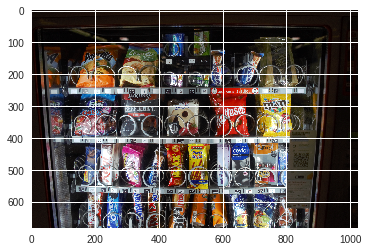

In [0]:
%matplotlib inline
#import IPython.display as display
import io
import tensorflow as tf
import PIL
from matplotlib.pyplot import imshow
import numpy as np

record_iterator = tf.python_io.tf_record_iterator(path="/content/gdrive/My Drive/Masterarbeit/ObjectDetection/TFRecords/2019_1_23_8_38_10_train.record")

for string_record in record_iterator:
  example = tf.train.Example()
  example.ParseFromString(string_record)
  
  print(dict(example.features.feature).keys())
  print(example.features.feature["image/height"].int64_list.value, example.features.feature["image/width"].int64_list.value)
  #print(type(example.features.feature["image/encoded"].bytes_list.value))
  encoded_jpg_io = io.BytesIO(example.features.feature["image/encoded"].bytes_list.value[0])
  pil_image = PIL.Image.open(encoded_jpg_io)
  print(pil_image.size)
  pil_image.save("tmp/observed.png")
  imshow(np.asarray(pil_image))
  break
  
#TODO get one of the pets
#record_iterator = tf.python_io.tf_record_iterator(path="/content/data/pet_faces_train.record-00000-of-00010")
#
#for string_record in record_iterator:
#  example = tf.train.Example()
#  example.ParseFromString(string_record)
#  
#  print(dict(example.features.feature).keys())
#  print(example.features.feature["image/height"].int64_list.value, example.features.feature["image/width"].int64_list.value)
#  #print(type(example.features.feature["image/encoded"].bytes_list.value))
#  encoded_jpg_io = io.BytesIO(example.features.feature["image/encoded"].bytes_list.value[0])
#  pil_image = PIL.Image.open(encoded_jpg_io)
#  print(pil_image.size)
#  pil_image.save("tmp/observed.png")
#  imshow(np.asarray(pil_image))
#  break

# GCloud Setup

ProjectId: objectdetection-229309

StorageAdress: gs://holoselecta_objectdetection/

tpuServiceAccount: service-727747150776@cloud-tpu.iam.gserviceaccount.com



## Init

In [0]:
!gcloud init

In [0]:
!gcloud config set project objectdetection-229309

Updated property [core/project].


## Setup 
(only done once)  

In [0]:
#!gsutil mb gs://holoselecta_objectdetection

Creating gs://holoselecta_objectdetection/...


In [0]:
#!curl -H "Authorization: Bearer $(gcloud auth print-access-token)" https://ml.googleapis.com/v1/projects/objectdetection-229309:getConfig

{
  "serviceAccount": "service-142071610554@cloud-ml.google.com.iam.gserviceaccount.com",
  "serviceAccountProject": "727747150776",
  "config": {
    "tpuServiceAccount": "service-727747150776@cloud-tpu.iam.gserviceaccount.com"
  }
}


In [0]:
#!gcloud projects add-iam-policy-binding objectdetection-229309  --member serviceAccount:service-727747150776@cloud-tpu.iam.gserviceaccount.com --role roles/ml.serviceAgent

Updated IAM policy for project [objectdetection-229309].
bindings:
- members:
  - serviceAccount:service-142071610554@compute-system.iam.gserviceaccount.com
  role: roles/compute.serviceAgent
- members:
  - serviceAccount:142071610554-compute@developer.gserviceaccount.com
  - serviceAccount:142071610554@cloudservices.gserviceaccount.com
  role: roles/editor
- members:
  - serviceAccount:service-142071610554@cloud-ml.google.com.iam.gserviceaccount.com
  - serviceAccount:service-727747150776@cloud-tpu.iam.gserviceaccount.com
  role: roles/ml.serviceAgent
- members:
  - user:grundtob@gmail.com
  role: roles/owner
etag: BwV_9My7Jes=
version: 1


## Copy Data


In [0]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03.tar.gz
!tar -xvf ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03.tar.gz
!rm ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03.tar.gz

--2019-01-24 18:55:20--  http://download.tensorflow.org/models/object_detection/faster_rcnn_nas_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.197.128, 2607:f8b0:4001:c1b::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.197.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1173756273 (1.1G) [application/x-tar]
Saving to: ‘faster_rcnn_nas_coco_2018_01_28.tar.gz’

faster_rcnn_nas_coc 100%[===================>]   1.09G   133MB/s    in 7.4s    

2019-01-24 18:55:28 (152 MB/s) - ‘faster_rcnn_nas_coco_2018_01_28.tar.gz’ saved [1173756273/1173756273]

faster_rcnn_nas_coco_2018_01_28/
faster_rcnn_nas_coco_2018_01_28/model.ckpt.index
faster_rcnn_nas_coco_2018_01_28/checkpoint
faster_rcnn_nas_coco_2018_01_28/pipeline.config
faster_rcnn_nas_coco_2018_01_28/model.ckpt.data-00000-of-00001
faster_rcnn_nas_coco_2018_01_28/model.ckpt.meta
faster_rcnn_nas_coco_2018_01_28/saved_model/
faster_rcnn_nas_coc

In [0]:
model = "faster_rcnn_nas_coco_2018_01_28"
config = "faster_rcnn_nasnet_holoselecta_cloud"
timestamp = "2019_1_23_8_38_10"
import shutil
shutil.copy(os.path.join(FLAGS_OD.pipeline_config_dir,"{}.config".format(config)),"pipeline.config")
if not os.path.exists("data"):
  os.mkdir("data")
shutil.copy(os.path.join(FLAGS_OD.label_map_dir,"{}.pbtxt".format(timestamp)), "data/label_map.pbtxt")
shutil.copy(os.path.join(FLAGS_OD.tf_records_dir,"{}_train.record".format(timestamp)), "data/train.record")
shutil.copy(os.path.join(FLAGS_OD.tf_records_dir,"{}_validate.record".format(timestamp)), "data/validate.record")
with open("timestamp", "+w") as file:
  file.write("timestamp for labelmap & records: {}\n".format(timestamp))
if os.path.exists("model") and os.path.exists("{}".format(model)):
  shutil.rmtree("model")
  shutil.copytree("{}".format(model), "model")
elif os.path.exists("{}".format(model)):
  shutil.copytree("{}".format(model), "model")
else:
  print("couldn't find a model to copy") 

try:
  shutil.rmtree("{}".format(model))
except:
  print("couldn't remove {}".format(model)) 

In [0]:
!gsutil -m rm -r gs://holoselecta_objectdetection/data/*
!gsutil -m rm -r gs://holoselecta_objectdetection/train/*
!gsutil -m cp data/* gs://holoselecta_objectdetection/data/
!gsutil cp data/label_map.pbtxt gs://holoselecta_objectdetection/train/
!gsutil cp timestamp gs://holoselecta_objectdetection/train/
!gsutil -m cp model/model.ckpt.* gs://holoselecta_objectdetection/data/
!gsutil cp pipeline.config gs://holoselecta_objectdetection/data/pipeline.config

Removing gs://holoselecta_objectdetection/data/model.ckpt.data-00000-of-00001#1548236904118271...
Removing gs://holoselecta_objectdetection/data/label_map.pbtxt#1548236895047859...
Removing gs://holoselecta_objectdetection/data/model.ckpt.index#1548236903880026...
Removing gs://holoselecta_objectdetection/data/model.ckpt.meta#1548236903998027...
Removing gs://holoselecta_objectdetection/data/train.record#1548236897483235...
Removing gs://holoselecta_objectdetection/data/validate.record#1548236895585569...
Removing gs://holoselecta_objectdetection/data/pipeline.config#1548236906345376...
/ [7/7 objects] 100% Done                                                       
Operation completed over 7 objects.                                              
Removing gs://holoselecta_objectdetection/train/label_map.pbtxt#1548236899678853...
Removing gs://holoselecta_objectdetection/train/pipeline.config#1548237274659275...
Removing gs://holoselecta_objectdetection/train/timestamp#1548236901769521.

In [0]:
!cd /content/tf/research; bash object_detection/dataset_tools/create_pycocotools_package.sh /tmp/pycocotools
!cd /content/tf/research; python setup.py sdist
!cd /content/tf/research; (cd slim && python setup.py sdist)

# Run

In [0]:
#check data is there should be 7 files
!gsutil ls gs://holoselecta_objectdetection/data

gs://holoselecta_objectdetection/data/label_map.pbtxt
gs://holoselecta_objectdetection/data/model.ckpt.data-00000-of-00001
gs://holoselecta_objectdetection/data/model.ckpt.index
gs://holoselecta_objectdetection/data/model.ckpt.meta
gs://holoselecta_objectdetection/data/pipeline.config
gs://holoselecta_objectdetection/data/train.record
gs://holoselecta_objectdetection/data/validate.record


In [0]:
!cd /content/tf/research; gcloud ml-engine jobs submit training `whoami`_object_detection_`date +%s` --job-dir=gs://holoselecta_objectdetection/train --packages dist/object_detection-0.1.tar.gz,slim/dist/slim-0.1.tar.gz,/tmp/pycocotools/pycocotools-2.0.tar.gz --module-name object_detection.model_tpu_main --runtime-version 1.9 --scale-tier BASIC_TPU --region us-central1 -- --model_dir=gs://holoselecta_objectdetection/train --tpu_zone us-central1 --pipeline_config_path=gs://holoselecta_objectdetection/data/pipeline.config
!cd /content/tf/research; gcloud ml-engine jobs submit training `whoami`_object_detection_eval_validation_`date +%s` --job-dir=gs://holoselecta_objectdetection/train --packages dist/object_detection-0.1.tar.gz,slim/dist/slim-0.1.tar.gz,/tmp/pycocotools/pycocotools-2.0.tar.gz --module-name object_detection.model_main --runtime-version 1.9 --scale-tier BASIC_GPU --region us-central1 -- --model_dir=gs://holoselecta_objectdetection/train --pipeline_config_path=gs://holoselecta_objectdetection/data/pipeline.config --checkpoint_dir=gs://holoselecta_objectdetection/train

Job [root_object_detection_1548236984] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe root_object_detection_1548236984

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs root_object_detection_1548236984
jobId: root_object_detection_1548236984
state: QUEUED


In [0]:
!gcloud ml-engine jobs list

JOB_ID                                            STATUS     CREATED
root_object_detection_eval_validation_1548237005  RUNNING    2019-01-23T09:50:13
root_object_detection_1548236984                  FAILED     2019-01-23T09:49:53
root_object_detection_eval_validation_1548233096  SUCCEEDED  2019-01-23T08:45:04
root_object_detection_eval_validation_1548229546  FAILED     2019-01-23T07:45:53
root_object_detection_eval_validation_1548195099  FAILED     2019-01-22T22:11:47
root_object_detection_1548195086                  SUCCEEDED  2019-01-22T22:11:38
root_object_detection_eval_validation_1548067548  SUCCEEDED  2019-01-21T10:45:57
root_object_detection_1548067435                  SUCCEEDED  2019-01-21T10:44:03


In [0]:
!gcloud ml-engine jobs describe root_object_detection_1548236984
!gcloud ml-engine jobs describe root_object_detection_eval_validation_1548237005

createTime: '2019-01-23T09:49:53Z'
etag: Wq1djYxvQG8=
jobId: root_object_detection_1548236984
startTime: '2019-01-23T09:51:07Z'
state: RUNNING
trainingInput:
  args:
  - --model_dir=gs://holoselecta_objectdetection/train
  - --tpu_zone
  - us-central1
  - --pipeline_config_path=gs://holoselecta_objectdetection/data/pipeline.config
  jobDir: gs://holoselecta_objectdetection/train
  packageUris:
  - gs://holoselecta_objectdetection/train/packages/6e5bda3b3a3de69c68e37f57beadfcbafd2d7a9633db9f136d21c0f9bc0093cb/object_detection-0.1.tar.gz
  - gs://holoselecta_objectdetection/train/packages/6e5bda3b3a3de69c68e37f57beadfcbafd2d7a9633db9f136d21c0f9bc0093cb/slim-0.1.tar.gz
  - gs://holoselecta_objectdetection/train/packages/6e5bda3b3a3de69c68e37f57beadfcbafd2d7a9633db9f136d21c0f9bc0093cb/pycocotools-2.0.tar.gz
  pythonModule: object_detection.model_tpu_main
  region: us-central1
  runtimeVersion: '1.9'
  scaleTier: BASIC_TPU
trainingOutput:
  consumedMLUnits: 0.24

View job in the Cloud Conso

In [0]:
#save results
#clean bucket
if not os.path.exists("train"):
  os.mkdir("train")
else:
  for the_file in os.listdir("train"):
    file_path = os.path.join("train", the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)
!gsutil -m cp -r gs://holoselecta_objectdetection/train/* train
now = datetime.now()
timestamp = "_".join([str(now.year), str(now.month), str(now.day), str(now.hour), str(now.minute), str(now.second)])
model_path = os.path.join(FLAGS_OD.model_dir,timestamp)
shutil.copytree("train", model_path)
!gsutil -m rm -r gs://holoselecta_objectdetection/train/*

Copying gs://holoselecta_objectdetection/train/checkpoint...
Copying gs://holoselecta_objectdetection/train/events.out.tfevents.1548195499.cmle-training-2435992349304765774...
Copying gs://holoselecta_objectdetection/train/model.ckpt-0.meta...
Copying gs://holoselecta_objectdetection/train/label_map.pbtxt...
Copying gs://holoselecta_objectdetection/train/model.ckpt-2000.data-00000-of-00001...
Copying gs://holoselecta_objectdetection/train/model.ckpt-0.data-00000-of-00001...
Copying gs://holoselecta_objectdetection/train/graph.pbtxt...
Copying gs://holoselecta_objectdetection/train/model.ckpt-2000.index...
Copying gs://holoselecta_objectdetection/train/model.ckpt-0.index...
Copying gs://holoselecta_objectdetection/train/model.ckpt-2000.meta...
Copying gs://holoselecta_objectdetection/train/pipeline.config...
Copying gs://holoselecta_objectdetection/train/timestamp...
Copying gs://holoselecta_objectdetection/train/eval_validation_data/events.out.tfevents.1548233381.cmle-training-69519515

# Tensorboard

In [0]:
class FLAGS_TB:
  # a temporary folder to run tensorboard on, doesn't seem to run on a Gdrive mounted folder
  tmp_graph_dir = "tmp_graph"
  
  # how many images fit horizontally in an image mosaic
  tb_mosaic_width = 5

In [0]:
import shutil
import os

if os.path.exists(FLAGS_TB.tmp_graph_dir):
  print("delete dir:")
  shutil.rmtree(FLAGS_TB.tmp_graph_dir)

delete dir:


In [0]:
import shutil

print("copy dir:")
shutil.copytree("gdrive/My Drive/Masterarbeit/ObjectDetection/Models/2019_1_23_9_13_50" ,FLAGS_TB.tmp_graph_dir)

copy dir:


'tmp_graph'

In [0]:
#!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab

tbc = TensorBoardColab(graph_path=FLAGS_TB.tmp_graph_dir)

Using TensorFlow backend.


Wait for 8 seconds...
TensorBoard link:
http://1d54274a.ngrok.io


# Test

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

In [0]:
# This is needed to display the images.
%matplotlib inline

In [0]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
model_timestamp = "2019_1_23_6_26_33"
PATH_TO_FROZEN_GRAPH = os.path.join(FLAGS_OD.model_dir,model_timestamp,"graph.pbtxt")

# List of the strings that is used to add correct label for each box.
label_map_timestamp = "2019_1_22_19_39_47"
PATH_TO_LABELS = os.path.join(FLAGS_OD.label_map_dir,"{}.pbtxt".format(label_map_timestamp))

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

/content/gdrive/My Drive/Masterarbeit/ObjectDetection/Models/2019_1_23_6_26_33/graph.pbtxt


DecodeError: ignored

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [0]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)